In [117]:
import warnings
warnings.filterwarnings('ignore')


import os
import sqlite3
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
 

import pandas as pd
import numpy as np
import keras

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score


from gensim.models import word2vec

[nltk_data] Downloading package punkt to /home/yura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yura/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Download the data

In [118]:
con = sqlite3.connect('/home/yura/PycharmProjects/news-filter/data/db/news_filter.db')

data = pd.read_sql_query("SELECT * FROM article", con)

### Data preprocessing

In [119]:
data.dropna(inplace=True)

data['category'] = data['category'].astype(int)

train, test = train_test_split(data, test_size = 0.3, random_state=1)

In [120]:
stops = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()

def content_to_wordlist(content):
    conent_text = re.sub("[^а-яА-Яa-zA-Z]"," ", content)

    words = conent_text.lower().split()

    words = [w for w in words if not w in stops]

    words = [wordnet_lemmatizer.lemmatize(w) for w in words]
    return(words)
    

In [121]:
train['content'] = train['content'].apply(content_to_wordlist)
test['content'] = test['content'].apply(content_to_wordlist)

In [122]:
model_w2v = word2vec.Word2Vec(train['content'], vector_size=300, window=10, workers=4, sg=1)

In [123]:
w2v_dict = {}
for word in model_w2v.wv.index_to_key:
    w2v_dict[word] = model_w2v.wv[word]
    

In [124]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v_dict.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [125]:
'''X_train = mean_vectorizer(w2v_dict).fit(train['content']).transform(train['content'])

X_test = mean_vectorizer(w2v_dict).fit(train['content']).transform(test['content'])'''

"X_train = mean_vectorizer(w2v_dict).fit(train['content']).transform(train['content'])\n\nX_test = mean_vectorizer(w2v_dict).fit(train['content']).transform(test['content'])"

In [126]:
'''log_reg  = LogisticRegression(solver='liblinear', C=9, random_state=42, n_jobs=-1)

log_reg.fit(X_train, train['category'])

log_reg_predict = log_reg.predict(X_test)

accuracy_score(test['category'], log_reg_predict)'''

"log_reg  = LogisticRegression(solver='liblinear', C=9, random_state=42, n_jobs=-1)\n\nlog_reg.fit(X_train, train['category'])\n\nlog_reg_predict = log_reg.predict(X_test)\n\naccuracy_score(test['category'], log_reg_predict)"

In [127]:
'''svc = SVC(kernel='linear', C=5, random_state=42)

svc.fit(X_train, train['category'])

svc_predict = svc.predict(X_test)

accuracy_score(test['category'], svc_predict)'''

"svc = SVC(kernel='linear', C=5, random_state=42)\n\nsvc.fit(X_train, train['category'])\n\nsvc_predict = svc.predict(X_test)\n\naccuracy_score(test['category'], svc_predict)"

In [128]:
#пропишем класс выполняющий tfidf преобразование.
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v_dict.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [129]:
X_train = tfidf_vectorizer(w2v_dict).fit(train['content']).transform(train['content'])

X_test = tfidf_vectorizer(w2v_dict).fit(train['content']).transform(test['content'])

In [130]:
log_reg  = LogisticRegression(solver='liblinear', C=9, random_state=42, n_jobs=-1)

log_reg.fit(X_train, train['category'])

log_reg_predict = log_reg.predict(X_test)

accuracy_score(test['category'], log_reg_predict)

0.7447698744769874

In [131]:
svc = SVC(kernel='linear', C=5, random_state=42)

svc.fit(X_train, train['category'])

svc_predict = svc.predict(X_test)

accuracy_score(test['category'], svc_predict)


0.7364016736401674

In [132]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input

In [133]:
model = Sequential()
model.add(Dense(64,input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   
   

In [134]:
history = model.fit(X_train, train['category'], validation_split=0.2, epochs=30, verbose=0)

In [135]:
model.evaluate(X_test, test['category'].values)

8/8 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.7280


[0.6074987053871155, 0.7280334830284119]

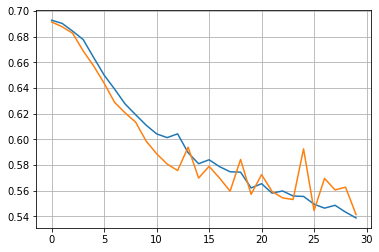

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.show;

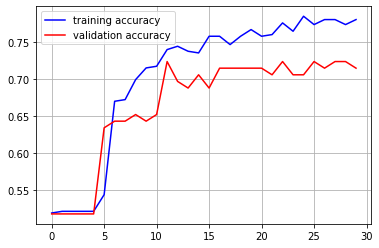

In [137]:
plt.plot(history.history['accuracy'], 'b', label='training accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='validation accuracy')
plt.legend()
plt.grid(True)
plt.show;